In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-03 12:58:35--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.01s   

2022-10-03 12:58:35 (5.08 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [75]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('AER_credit_card_data.csv')


# Preparation

In [76]:
df.card = (df.card == 'yes').astype(int)

In [77]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

# Question 1

In [78]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [79]:
numerical = ['reports','age','income','share','expenditure','dependents','months','majorcards','active']
categorical = ['owner', 'selfemp']

In [80]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [81]:
for cat in numerical:
    auc = roc_auc_score(y_train, df_train[cat])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[cat])
    print(cat, auc)

reports 0.7166629860689376
age 0.5240020979407055
income 0.5908049467233478
share 0.989183643423692
expenditure 0.991042345276873
dependents 0.5327757227773791
months 0.5294217780967629
majorcards 0.5343859842838476
active 0.6043173411362006


In [82]:
# Answer: share

# Question 2

In [83]:
list(df.columns)

['card',
 'reports',
 'age',
 'income',
 'share',
 'expenditure',
 'owner',
 'selfemp',
 'dependents',
 'months',
 'majorcards',
 'active']

In [84]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [85]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [86]:
train_dicts = df_train[cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [87]:
roc_auc_score(y_val, y_pred)

0.995171242063847

In [88]:
# Answer: 0.995

# Question 3

In [98]:
def conf_matrix(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores
df_scores = conf_matrix(y_val, y_pred)

In [99]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

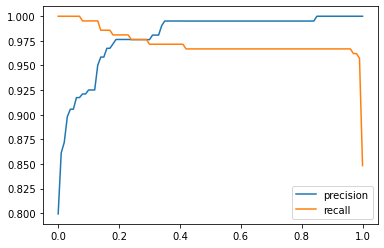

In [100]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')
plt.legend()
plt.show()

In [101]:
# Answer: 0.3

# Question 4

In [104]:
df_scores['f1'] = 2 * df_scores['r'] * df_scores['p'] / (df_scores['r'] + df_scores['p'])

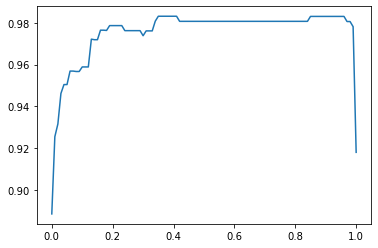

In [105]:
plt.plot(df_scores.threshold, df_scores.f1)

# Question 5

In [107]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [110]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [114]:
from sklearn.model_selection import KFold

In [119]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


In [120]:
# Answer 0.003

# Question 6

In [122]:
from tqdm.auto import tqdm

In [131]:
n_splits=5
for C in tqdm([0.01, 0.1, 1, 10, 20, 50, 100]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.5f +- %.5f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.01 0.99645 +- 0.00274
C=0.1 0.99645 +- 0.00274
C=1 0.99645 +- 0.00274
C=10 0.99645 +- 0.00274
C=20 0.99645 +- 0.00274
C=50 0.99645 +- 0.00274
C=100 0.99645 +- 0.00274


In [ ]:
# Answer 0.01